In [413]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

### Machine Learning

In [414]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

#df = df[df['make_playoffs'] == 1]
print(list(df.columns))

['Season', 'Team', 'team_id', 'Quarterback', 'conference', 'divisions', 'round', 'champion_share', 'champion', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'te

In [415]:
data_columns = ['QBSRC_rk','W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs',
                'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', '7_seed', 'playoff_games', 'playoff_wins', 
                'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 
                'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp',
                'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 
                'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A',
                'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%',
                'team_offense_TO%', 'team_offense_EXP', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply',
                'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
                'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 
                'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 
                'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 
                'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP',
                'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 
                'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C',
                'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 
                'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP', 'pso', 'over500_rec', 'over600_rec', 'rec_7pt_or_less', 
                'sum_games_7pts_or_less', 'over500_PD', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_opoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 
                'sum_champion_shares', 'sum_champions', 'sum_playoff_games', 'sum_mvp_shares_L4S', 'sum_dpoy_shares_L4S', 'sum_player_L1S_cs',
                'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference_record', 'divisions_record', 'sum_coach_playoff_games',
                'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_FG%', 'Scoring_Lng', 'Scoring_XP%', 'break_even_over500_PD', 
                'sum_QB_playoff_games', 'QB_Age', 'sum_QB_mvp_shares', 'sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs',
                  'sum_franchise_L8S_cs', 'team_rating_custom', 'QB_2_or_more_GWD', '500_rec_7pt_or_less', '625_rec',  'SRS_greater_than_1.5_pts', 'team_rating_custom', 'rank_team_rating_custom', 'top_5_team_rating_custom', 'top_7_QBSRC']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [416]:
correlation_matrix = data.corr()

correlation_threshold = .5

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)


print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'QBSRC_rk', 'PA', 'SoS', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', '7_seed', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_TO', 'team_offense_Passing_Att', 'team_offense_Rushing_Y/A', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_EXP', 'team_defense_Tot Yds & TO_TO', 'team_defense_Rushing_Y/A', 'passing_offense_Lng', 'passing_offense_Y/C', 'passing_offense_Sk', 'passing_offense_4QC', 'pso', 'sum_games_7pts_or_less', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 'sum_champions', 'conference_record', 'divisions_record', 'sum_coach_playoff_games', 'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_Lng', 'QB_Age', '500_rec_7pt_or_less'

Columns that were removed:
'625_rec', 'team_defense_Tot Yds & TO_Yds', 'team_offense_Passing_NY/A', 'MoV', 'team_defense_Tot Yds & TO_Y/P', 'OSRS', 'team_offense_PF', 'team_rating_custom', 'top_5_team_rating_custom', 

In [417]:
features = ['top_5_team_rating_custom', '40_50+_perc_x_makes',
           'sum_coach_playoff_games', 'sum_dpoy_shares', 'sum_cpoy_shares', 'sum_champions', 'sum_all_pro','SRS_greater_than_1.5_pts',
            
            'SoS', 'pso',
           'team_offense_Tot Yds & TO_TO', 'team_offense_Passing_Att', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Penalties_Pen' , 
            'team_defense_Tot Yds & TO_Ply', 'team_defense_Rushing_Yds', 'passing_offense_Y/C',
            'passing_offense_Sk', 'passing_offense_4QC', 'sum_mvp_shares', 'sum_mvp_shares_L4S', 'QB_2_or_more_GWD',

             'team_defense_EXP', 'sum_playoff_games', 'sum_opoy_shares', 'sum_player_L3S_cs','500_rec_7pt_or_less', 'sum_franchise_L1S_cs', 'team_rating_custom', 'QBSRC_rk'
           ]

            
num_features = len(features)

print(f"Number of features: {num_features}")

Number of features: 31


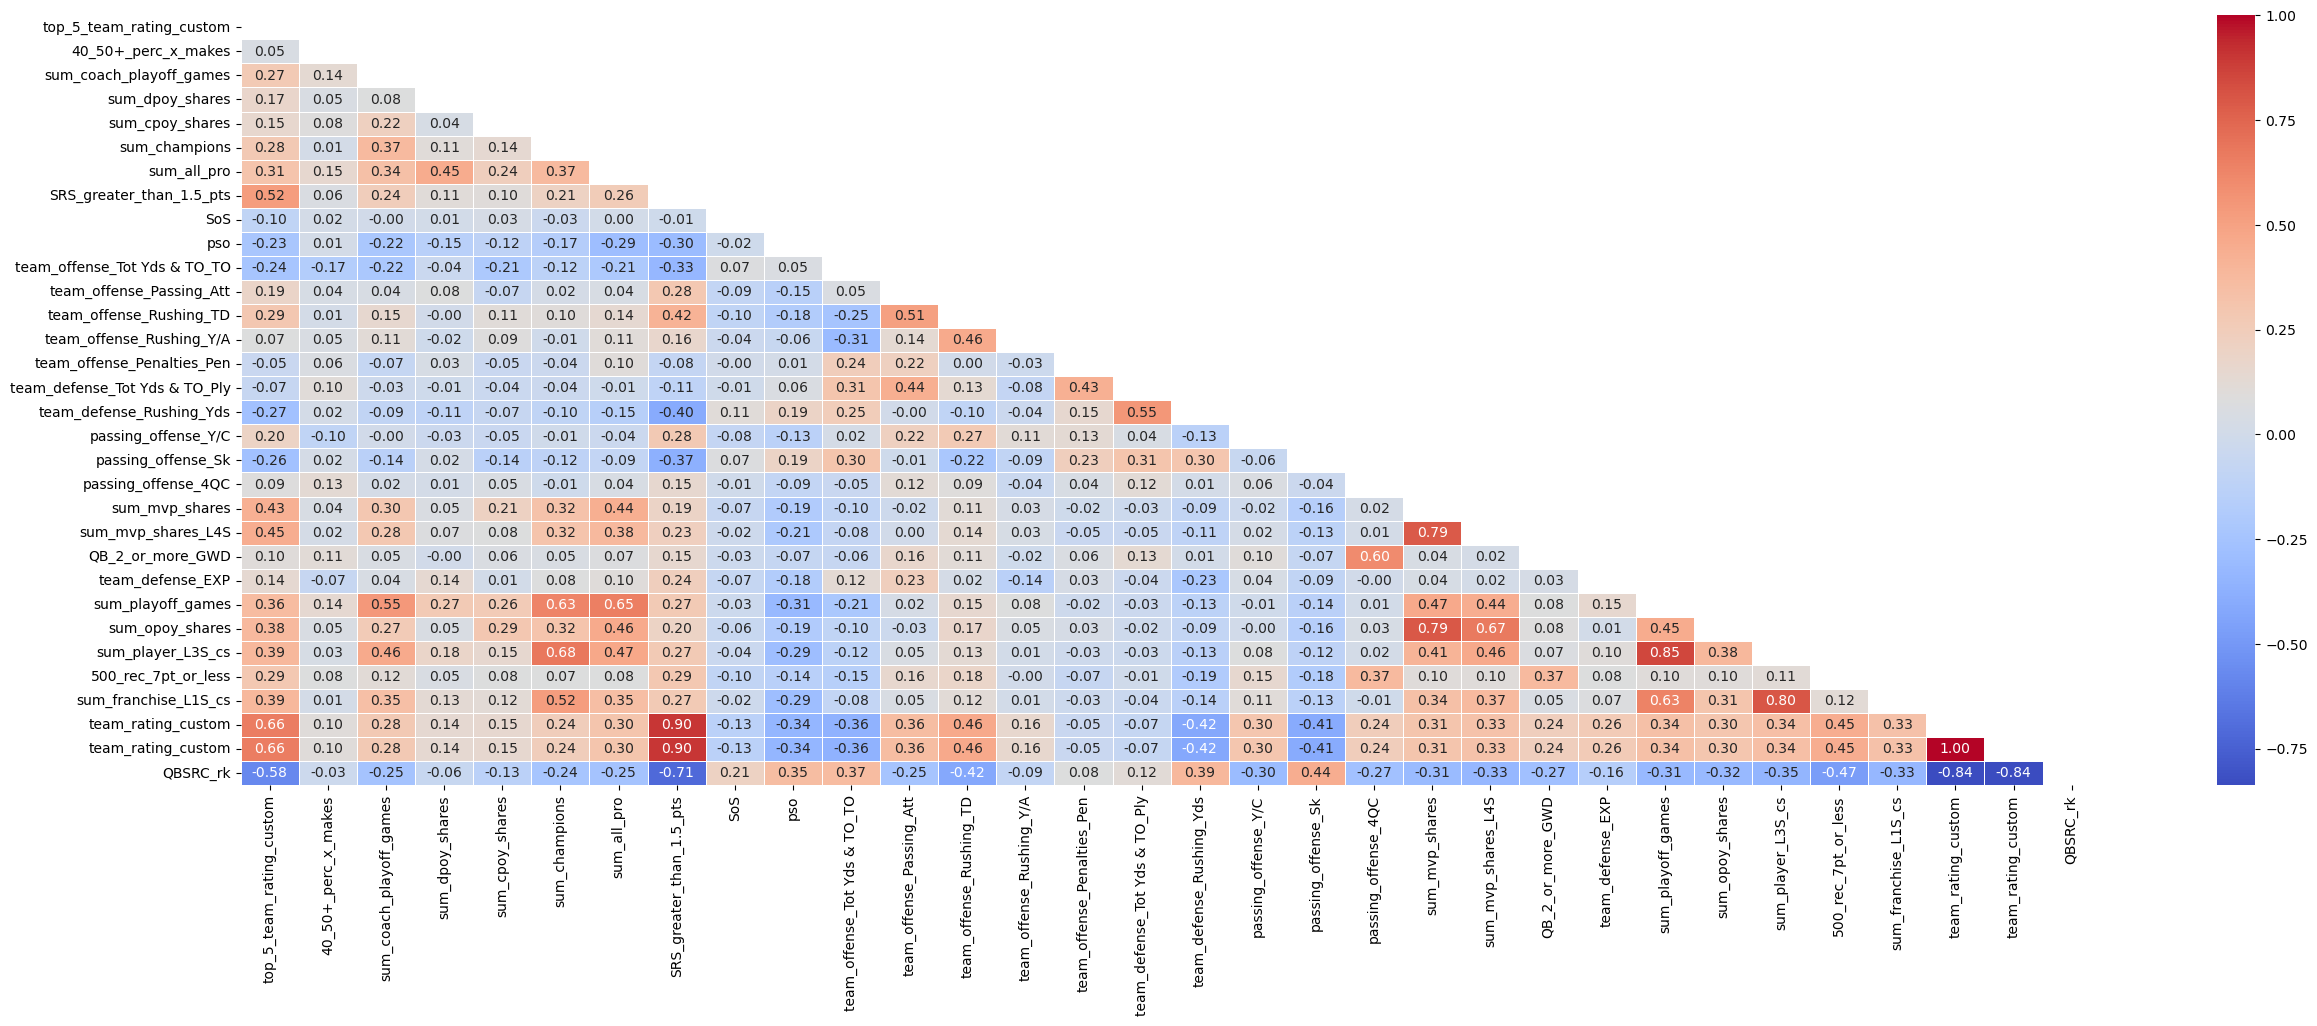

In [418]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

### Random-Forest Regression:

Results:

    Season                 Team  champion_share  predicted_cs
45    2024  San Francisco 49ers            0.75      0.514677
42    2024     Baltimore Ravens            0.50      0.514294
61    2024   Kansas City Chiefs            1.00      0.341073
43    2024       Dallas Cowboys            0.00      0.336965
59    2024        Buffalo Bills            0.25      0.163640
44    2024        Detroit Lions            0.50      0.151493
62    2024       Miami Dolphins            0.00      0.134119
33    2024   Cincinnati Bengals            0.00      0.130220
53    2024     Cleveland Browns            0.00      0.119915
57    2024  Philadelphia Eagles            0.00      0.108612
58    2024     Los Angeles Rams            0.00      0.092102
34    2024   New Orleans Saints            0.00      0.057100
36    2024    Green Bay Packers            0.25      0.024077
39    2024        New York Jets            0.00      0.015367
------------------------------------------------------------

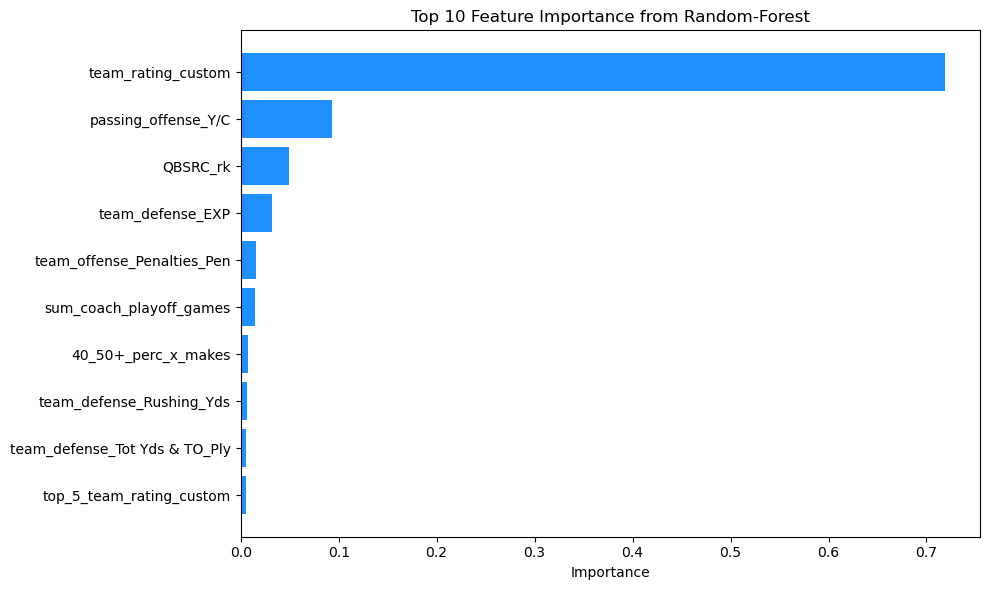

In [448]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

#df = df[df['make_playoffs'] == 1]

df.drop(df[df['Season'] < 2005].index, inplace=True)

test_season = 2024

train = df[df["Season"] < test_season].copy()
test = df[df["Season"] == test_season].copy()


sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rf = RandomForestRegressor(
    n_estimators=150,        
    max_depth=3,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=5          
)

rf.fit(train[features], train["champion_share"])

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

rf_importance = rf.feature_importances_
sorted_idx = np.argsort(rf_importance)[::-1]
top_features = [features[i] for i in sorted_idx[:10]]
importance_values = rf_importance[sorted_idx[:10]]

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create the horizontal bar chart
ax.barh(top_features, importance_values, color='dodgerblue')
ax.set_title('Top 10 Feature Importance from Random-Forest')
ax.set_xlabel('Importance') 
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [449]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Kansas City Chiefs               1.0        0.341073     1      2024               1.0        0.341073               3

AP Champion:  0.3333333333333333


In [450]:
rf_reg_combined_predictions = pd.DataFrame(columns=["Season","Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

#backtest_seasons = [2008,2009,2010,2011,2012,2013,2014, ]
backtest_seasons = [2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion_share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rf_reg_combined_predictions.to_csv("rf_reg_nfl_preds.csv", index=False)

Champion AP for Season 2015: 0.33 | Reciprocal: 3.0 | NDCG: 0.81

C:\Users\allen\AppData\Local\Temp\ipykernel_3212\2583728911.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)



Champion AP for Season 2016: 1.0 | Reciprocal: 1.0 | NDCG: 0.98
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0 | NDCG: 0.91
Champion AP for Season 2018: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2019: 0.5 | Reciprocal: 2.0 | NDCG: 0.84
Champion AP for Season 2020: 0.33 | Reciprocal: 3.0 | NDCG: 0.63
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0 | NDCG: 0.91
Champion AP for Season 2022: 1.0 | Reciprocal: 1.0 | NDCG: 0.91
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2024: 0.33 | Reciprocal: 3.0 | NDCG: 0.88

Top 5 Predicted Teams for Season 2015:
                     Team  predicted_cs  champion_share
340        Denver Broncos      0.479354            0.25
351      Seattle Seahawks      0.419230            0.75
322  New England Patriots      0.382249            1.00
341     Green Bay Packers      0.380600            0.50
333    Indianapolis Colts      0.245301            0.50
327        Dallas Cowboys      0.211457      

Top 10 Features:
['team_rating_custom', 'passing_offense_Y/C', 'QBSRC_rk', 'team_defense_EXP', 'sum_coach_playoff_games', 'team_offense_Penalties_Pen', 'team_defense_Tot Yds & TO_Ply', 'SoS', 'team_offense_Rushing_TD', 'top_5_team_rating_custom']


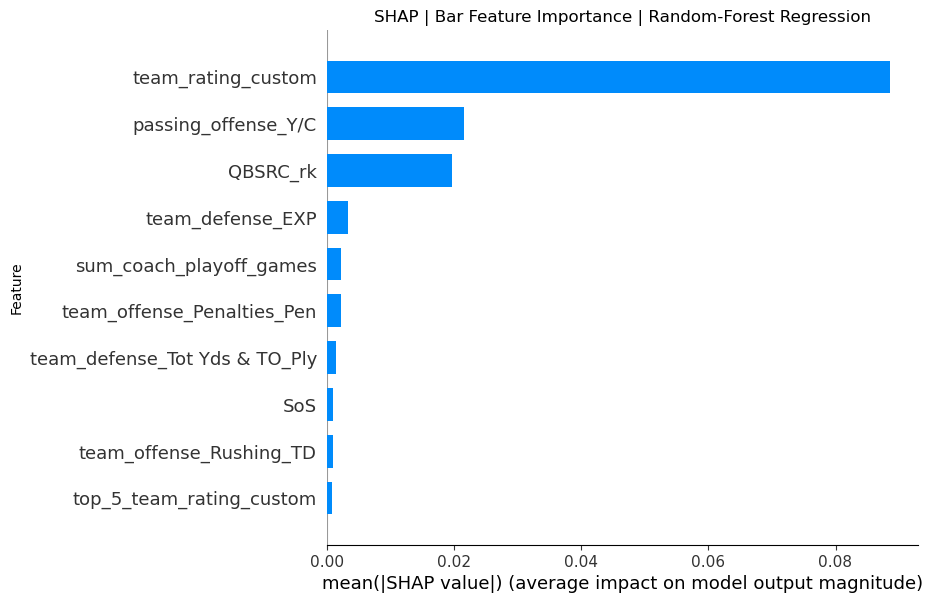

In [451]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Bar Feature Importance | Random-Forest Regression')

plt.savefig("rf_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['team_rating_custom', 'passing_offense_Y/C', 'QBSRC_rk', 'team_defense_EXP', 'sum_coach_playoff_games', 'team_offense_Penalties_Pen', 'team_defense_Tot Yds & TO_Ply', 'SoS', 'team_offense_Rushing_TD', 'top_5_team_rating_custom']


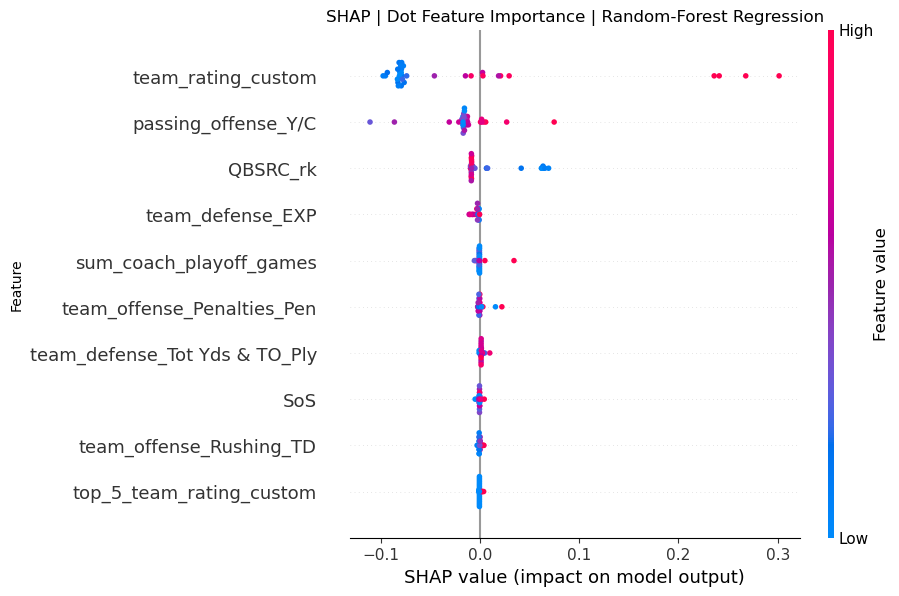

In [452]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Random-Forest Regression')

plt.savefig("rf_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_dot.png")

plt.ylabel("Feature")
plt.show()